# Notebook 2 - Inference

In this notebook we use `harissa` to perform network inference from a small dataset with 4 genes.

In [1]:
import numpy as np
from pathlib import Path

from harissa import NetworkModel, NetworkParameter
from harissa.core import Dataset

fname = 'data.npz'
data_path = Path(fname)

## Network

Let us start by defining a test network which will represent the ground truth. Note that the underlying dynamical model has quantitative parameters.

In [2]:
# Initialize model parameters with 4 genes
param = NetworkParameter(4)

# Set degradation rates
param.degradation_rna[:] = 1.0
param.degradation_protein[:] = 0.2

# Set creation rates
param.creation_rna[:] = param.degradation_rna * param.scale() 
param.creation_protein[:] = param.degradation_protein * param.scale()

# Set basal activities
param.basal[1:] = -5.0

# Set interactions
param.interaction[0,1] = 10.0
param.interaction[1,2] = 10.0
param.interaction[1,3] = 10.0
param.interaction[3,4] = 10.0
param.interaction[4,1] = -10.0
param.interaction[2,2] = 10.0
param.interaction[3,3] = 10.0

# Initialize model
model = NetworkModel(param)

The `harissa.utils` module provides `build_pos` and `plot_network` to visualize networks.

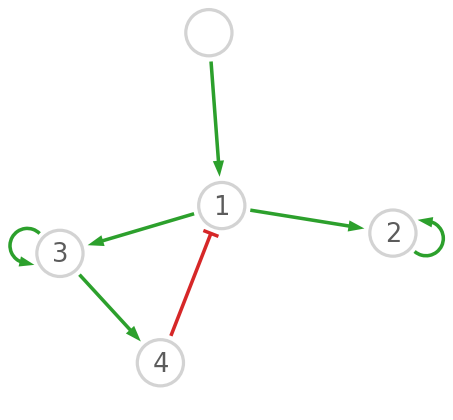

In [3]:
import matplotlib.pyplot as plt
from harissa.plot import build_pos, plot_network

# Number of genes including stimulus
G = param.basal.size

# Node labels and positions
names = [''] + [f'{i+1}' for i in range(G)]
pos = build_pos(param.interaction) * 0.8

# Draw the network
fig = plt.figure(figsize=(5,5))
plot_network(param.interaction, pos, axes=fig.gca(), names=names, scale=3)

## Dataset

We start by generating a sample time-course scRNA-seq dataset: here the main function is `model.simulate()`. The dynamical model is first run during a certain time without stimulus (`burnin` parameter) before activating it at $t=0$. Each single cell is then collected at a particular time point $t > 0$ during the simulated experiment: in this example there are 10 experimental time points and `C`/10 cells per time point.

In [4]:
# Simulate a time-course scRNA-seq dataset
if not data_path.is_file():
    times = np.floor(np.linspace(0.0, 20.0, 10))
    C = 1000
    n_cells_per_time_point = C // times.size # 100
    data = model.simulate_dataset(
        time_points = times, 
        n_cells=n_cells_per_time_point, 
        burn_in_duration=5.0
    )
    # Save data in basic format
    data.save(fname)
    print(f'Dataset file {fname} has been generated.')
else:
    data = Dataset.load(fname)
    print(f'Dataset file {fname} loaded.')

Dataset file data.npz loaded.


Note that each scRNA-seq count is obtained by sampling from a Poisson distribution whose rate (mean) parameter is given by the corresponding continuous-valued mRNA level from the stochastic dynamical model. A typical way to implement technical factors (efficiency of reverse transcription, sequencing depth, etc.) would be to first multiply, before applying the Poisson distribution, the continuous values by scaling factors.

In [5]:
print(data)

Dataset(time_points=array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2

Each row corresponds to a single cell; the first column contains time points, while other columns contain gene expression counts.

## Network Inference

Here the main function is `model.fit()`. The first call may take a while due to the Numba compilation (activated by default).

In [6]:
model = NetworkModel()
# Calibrate the model
model.fit(data)
# Show inferred links
print(model.interaction)

[[-- 0.18474878944530368 0.057804360029282624 0.049932447580491195
  0.01872017165788602]
 [-- 0.6718837841627131 0.11786103501152465 0.10479103015454667
  0.026714526149408103]
 [-- 0.156511807840515 0.30309053061899954 0.08344383264163142
  0.037794452838910676]
 [-- 0.1408110069899492 0.08557091535829031 0.2636652788804529
  0.07941719881846389]
 [-- 0.02781251671348925 0.042073241381995294 0.08956113982379557
  0.12149434180918307]]



Note that the first column of `model.inter` will always be 0 since the stimulus (gene 0) has no feedback by hypothesis. In order to better visualize the results, we can apply a cutoff to edge weights:

In [7]:
cutoff = 1
inter_c = (np.abs(model.interaction) > cutoff) * model.interaction
print(inter_c) 

[[-- 0.0 0.0 0.0 0.0]
 [-- 0.0 0.0 0.0 0.0]
 [-- 0.0 0.0 0.0 0.0]
 [-- 0.0 0.0 0.0 0.0]
 [-- 0.0 0.0 0.0 0.0]]


Hopefully this looks nice!

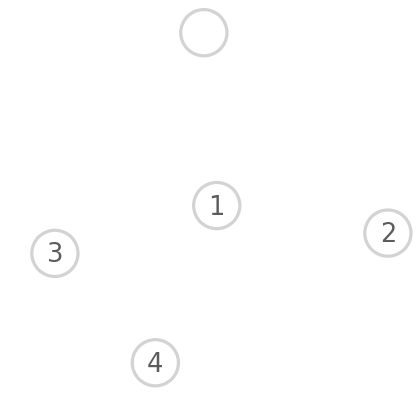

In [8]:
# Draw the network
fig = plt.figure(figsize=(5,5))
plot_network(inter_c, pos, axes=fig.gca(), names=names, scale=3)

Note that self-interactions are notoriously difficult to infer; they are usually not considered in performance evaluations.

### Option: disable Numba

To perform inference without Numba acceleration, set the `use_numba` option to `False` (useful when Numba is not available or generates errors).

In [9]:
from harissa.inference import Hartree
model = NetworkModel(inference=Hartree(use_numba=False))
# Calibrate the model
model.fit(data)
# Show inferred links
print(model.interaction)

[[-- 0.18474878944530368 0.057804360029282624 0.049932447580491195
  0.01872017165788602]
 [-- 0.6718837841627131 0.11786103501152465 0.10479103015454667
  0.026714526149408103]
 [-- 0.156511807840515 0.30309053061899954 0.08344383264163142
  0.037794452838910676]
 [-- 0.1408110069899492 0.08557091535829031 0.2636652788804529
  0.07941719881846389]
 [-- 0.02781251671348925 0.042073241381995294 0.08956113982379557
  0.12149434180918307]]


You can now delete `data.txt` and try to generate new data with different values for `C` (number of cells) to see its impact on performance.